In [1]:
from pathlib import Path
from imageio import imwrite
import rasterio
import numpy as np
import numpy as np
from tqdm import tqdm
import rasterio

> For Potsdam, 18 out of the 24 images are selected for model training. \
> The tile 04-12 is discarded due to possible mislabelling. \
> The remaining 5 images (with tile IDs 02-12, 03-12, 05-12, 06-12 and 07-12) are employed for the validation set.

> Images are cropped into 512 × 512 patches for Potsdam and into 256 × 256 for Vaihingen in a non-
> overlapping fashion for the model training and validation.

In [ ]:
ROOT_DIR = Path('.').resolve().parent

DATASETS_DIR = ROOT_DIR / "datasets"
POTSDAM_DIR = DATASETS_DIR / "Potsdam"
assert POTSDAM_DIR.exists(), f"Potsdam dataset not found in {POTSDAM_DIR}"

In [3]:
ortho = POTSDAM_DIR / "2_Ortho_RGB"
labels = POTSDAM_DIR / "5_Labels_for_participants"

# LABEL_POSTFIX = '_label_noBoundary' # 5...no_border
LABEL_POSTFIX = '_label'

In [77]:
ortho_tifs = sorted(ortho.glob("*.tif"))
print(len(ortho_tifs))

labels_tifs = sorted(labels.glob("*.tif"))
print(len(labels_tifs))

38
24


In [86]:
ortho_tifs_filtered = [o for o in ortho_tifs if any(o.stem.replace("_RGB", LABEL_POSTFIX) == l.stem for l in labels_tifs)]
print(f"Filtered ortho_tifs: {len(ortho_tifs_filtered)}")

Filtered ortho_tifs: 24


In [87]:
def filter_tiles(ortho, label) -> int:
    """ 0 to train, 1 to val, -1 to discard """

    tile_id = "_".join(ortho.stem.split("_")[2:4])

    if tile_id == "4_12":
        return -1  # discard
    elif tile_id in {"2_12", "3_12", "5_12", "6_12", "7_12"}:
        return 1   # validation
    else:
        return 0   # training

In [12]:
OUT_DIR = DATASETS_DIR / "Potsdam-tiles-512"
OUT_DIR.mkdir(exist_ok=True)

In [ ]:
for ortho_tif in tqdm(ortho_tifs_filtered):
    label_tif = labels / ortho_tif.name.replace("_RGB", LABEL_POSTFIX)

    split = filter_tiles(ortho_tif, label_tif)
    if split == -1:
        continue

    split_dir = "train" if split == 0 else "val"
    out_ortho_dir = OUT_DIR / split_dir / "images"
    out_label_dir = OUT_DIR / split_dir / "labels"
    out_ortho_dir.mkdir(parents=True, exist_ok=True)
    out_label_dir.mkdir(parents=True, exist_ok=True)

    with rasterio.open(ortho_tif) as ortho_ds, rasterio.open(label_tif) as label_ds:
        width = ortho_ds.width
        height = ortho_ds.height

        patch_size = 512
        for i in range(0, width, patch_size):
            for j in range(0, height, patch_size):
                work_i, work_j = i, j

                # Handle edge cases (cropping last tile)
                if not i + patch_size <= width:
                    work_i = width - patch_size
                if not j + patch_size <= height:
                    work_j = height - patch_size

                # Read data
                # rasterio returns (Channels, Height, Width)
                ortho_patch = ortho_ds.read(window=rasterio.windows.Window(work_i, work_j, patch_size, patch_size))
                label_patch = label_ds.read(window=rasterio.windows.Window(work_i, work_j, patch_size, patch_size))

                out_ortho_path = out_ortho_dir / f"{ortho_tif.stem}_x{work_i}_y{work_j}.png"
                out_label_path = out_label_dir / f"{label_tif.stem}_x{work_i}_y{work_j}.png"

                # --- PROCESS ORTHO PHOTO ---
                # Transpose to (H, W, C)
                ortho_patch_img = ortho_patch.transpose(1, 2, 0)
                if ortho_patch_img.dtype != 'uint8':
                    ortho_patch_img = (ortho_patch_img / ortho_patch_img.max() * 255).astype('uint8')
                
                imwrite(str(out_ortho_path), ortho_patch_img)

                # --- PROCESS LABELS (RGB -> 0-N Integers) ---
                # 1. Transpose (3, H, W) -> (H, W, 3)
                # We slice [:3] just in case there is a 4th Alpha band
                label_rgb = label_patch[:3, :, :].transpose(1, 2, 0)

                # 2. Create blank mask (H, W)
                mask = np.zeros(label_rgb.shape[:2], dtype=np.uint8)

                # 3. Map Colors to Integers
                # Impervious surfaces (White) -> 0
                mask[np.all(label_rgb == (255, 255, 255), axis=-1)] = 0
                # Building (Blue) -> 1
                mask[np.all(label_rgb == (0, 0, 255), axis=-1)] = 1
                # Low vegetation (Cyan) -> 2
                mask[np.all(label_rgb == (0, 255, 255), axis=-1)] = 2
                # Tree (Green) -> 3
                mask[np.all(label_rgb == (0, 255, 0), axis=-1)] = 3
                # Car (Yellow) -> 4
                mask[np.all(label_rgb == (255, 255, 0), axis=-1)] = 4
                # Clutter/Background (Red) -> 5
                mask[np.all(label_rgb == (255, 0, 0), axis=-1)] = 5

                # 4. Save Mask
                imwrite(str(out_label_path), mask)

100%|██████████| 24/24 [05:50<00:00, 14.61s/it]


In [ ]:
import pandas as pd

In [14]:
postdam_static = DATASETS_DIR/'Potsdam-static'
df_classes = pd.read_csv(postdam_static/'classes.csv')
df_classes

,class_id,name,color_name,color
0,0,Impervious surfaces,white,"(255, 255, 255)"
1,1,Buildings,blue,"(0, 0, 255)"
2,2,Low vegetation,cyan,"(0, 255, 255)"
3,3,Trees,green,"(0, 255, 0)"
4,4,Cars,yellow,"(255, 255, 0)"
5,5,Clutter,red,"(255, 0, 0)"
6,6,Undefined,black,"(0, 0, 0)"


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

def hex2rgb(hex_color):
    if isinstance(hex_color, tuple) or isinstance(hex_color, list):
        return tuple(hex_color)
    if hex_color.startswith('#'):
        hex_color = hex_color.lstrip('#')
        t = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    else:
        t = tuple(int(x.strip()) for x in hex_color.strip('()').split(','))
    return t

ssd_cmap = ListedColormap(
    df_classes['color'].apply(lambda x: np.array(hex2rgb(x))/255.0).to_list(),
    name='skyscapes',
    N = len(df_classes)
) 

potsdam_plot_kwargs = {
    'vmin': 0,
    'vmax': len(df_classes) - 1,
    'cmap': ssd_cmap
}

potsdam_legend_kwargs = {
    'handles': [
        Patch(color=potsdam_plot_kwargs['cmap'](i), label=name) 
        for i, name in enumerate(df_classes.name.values)
    ],
    'bbox_to_anchor': (1.05, 1),
    'loc': 'upper left',
    'borderaxespad': 0.,
}

Image: top_potsdam_2_11_RGB_x4096_y2560.png
Label: top_potsdam_2_11_label_x4096_y2560.png
Unique values in label image: [0 2 3 4]


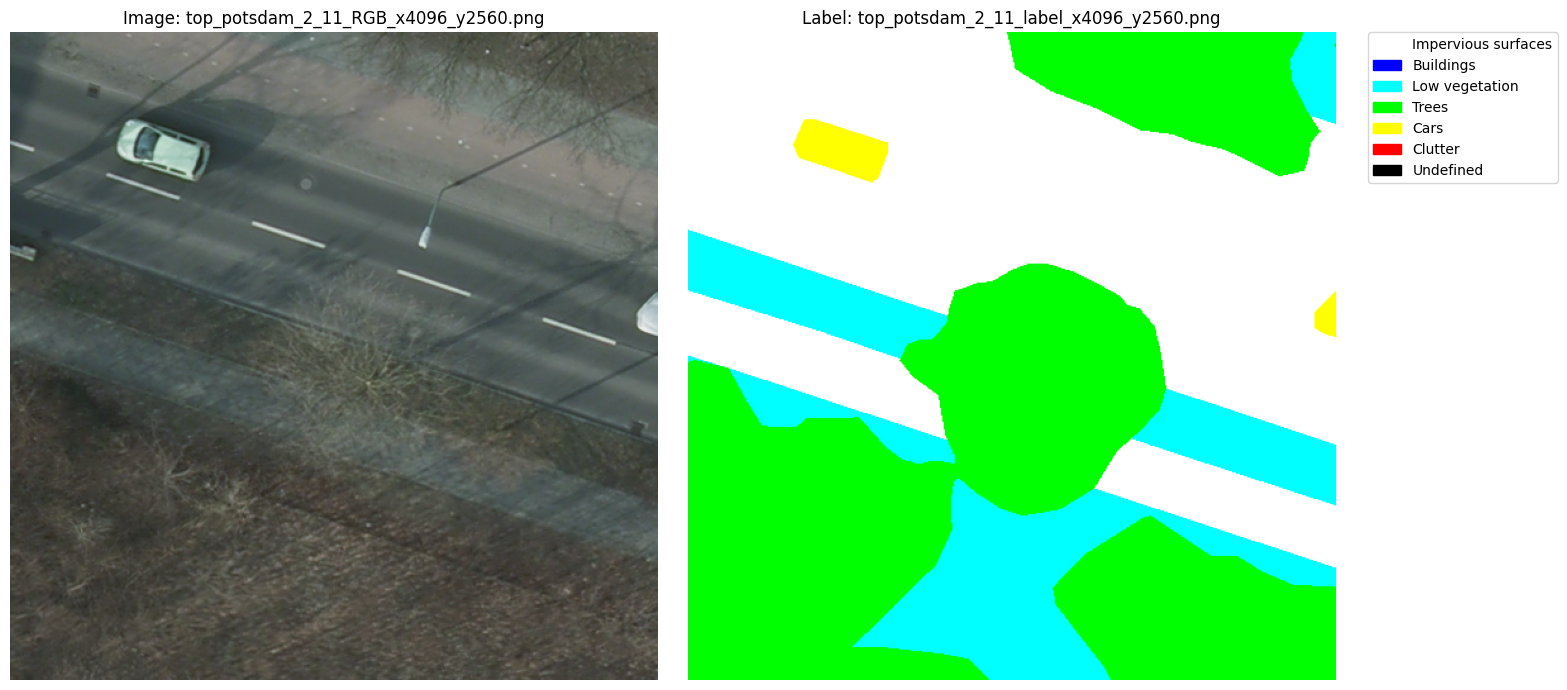

In [35]:
import random
import numpy as np
import cv2


# train_label_dir = OUT_DIR / "train" / "labels"
# train_label_paths = list(train_label_dir.glob("*.png"))

train_image_dir = OUT_DIR / "train" / "images"
train_image_paths = list(train_image_dir.glob("*.png"))

# Get all training image and label paths
idx = random.randint(0, len(train_image_paths) - 1)
img_path = train_image_paths[idx]
label_path = OUT_DIR / "train" / "labels" / img_path.name.replace("_RGB", LABEL_POSTFIX)

# Load the image (RGB)
img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load the label (grayscale)
label_img = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE)

print("Image:", img_path.name)
print("Label:", label_path.name)
print("Unique values in label image:", np.unique(label_img))

plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Image: {img_path.name}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(label_img, **potsdam_plot_kwargs)
plt.legend(**potsdam_legend_kwargs)
plt.title(f"Label: {label_path.name}")
plt.axis('off')


plt.tight_layout()
plt.show()

# mean std calculation

In [16]:
import cv2
import cv2
import numpy as np
from tqdm import tqdm

train_image_dir = OUT_DIR / "train" / "images"
train_image_paths = list(train_image_dir.glob("*.png"))

means = []
stds = []

# ... setup paths ...

for img_path in tqdm(train_image_paths, desc="Calculating mean/std"):
    # 1. Read BGR
    img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    
    # 2. CRITICAL: Convert BGR -> RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 3. Normalize & Append
    img = img.astype(np.float32) / 255.0
    means.append(np.mean(img, axis=(0, 1)))
    stds.append(np.std(img, axis=(0, 1)))

# Calculate final stats
# Convert to standard Python lists or Tensors for FastAI
ds_mean = np.mean(means, axis=0).tolist()
ds_std = np.mean(stds, axis=0).tolist()

print("Mean (RGB):", ds_mean)
print("Std (RGB):", ds_std)

Calculating mean/std:   0%|          | 5/2592 [00:00<00:55, 46.61it/s]

Calculating mean/std: 100%|██████████| 2592/2592 [00:47<00:00, 54.88it/s]

Mean (RGB): [0.3362390100955963, 0.35974231362342834, 0.3330190181732178]
Std (RGB): [0.11687745898962021, 0.11572890728712082, 0.12002932280302048]


# class balance calculation

In [17]:
import numpy as np
from collections import Counter

# Initialize counter for all classes
class_counts = Counter()

# Loop through all label images and count pixels per class
for label_path in tqdm(train_label_paths, desc="Calculating class balance"):
    label_img = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE)
    unique, counts = np.unique(label_img, return_counts=True)
    class_counts.update(dict(zip(unique, counts)))

# Convert to array for easier normalization
total_pixels = sum(class_counts.values())
class_balance = {df_classes.loc[df_classes['class_id'] == k, 'name'].values[0]: v / total_pixels for k, v in class_counts.items()}

print("Class pixel counts:", dict(class_counts))
print("Class balance (fraction of total pixels):")
for class_name, frac in class_balance.items():
    print(f"{class_name}: {frac:.4f}")

Calculating class balance: 100%|██████████| 2592/2592 [00:08<00:00, 319.36it/s]

Class pixel counts: {np.uint8(0): np.int64(182913830), np.uint8(2): np.int64(166483957), np.uint8(3): np.int64(108022172), np.uint8(4): np.int64(10543921), np.uint8(1): np.int64(170043136), np.uint8(5): np.int64(41470232)}
Class balance (fraction of total pixels):
Impervious surfaces: 0.2692
Low vegetation: 0.2450
Trees: 0.1590
Cars: 0.0155
Buildings: 0.2503
Clutter: 0.0610


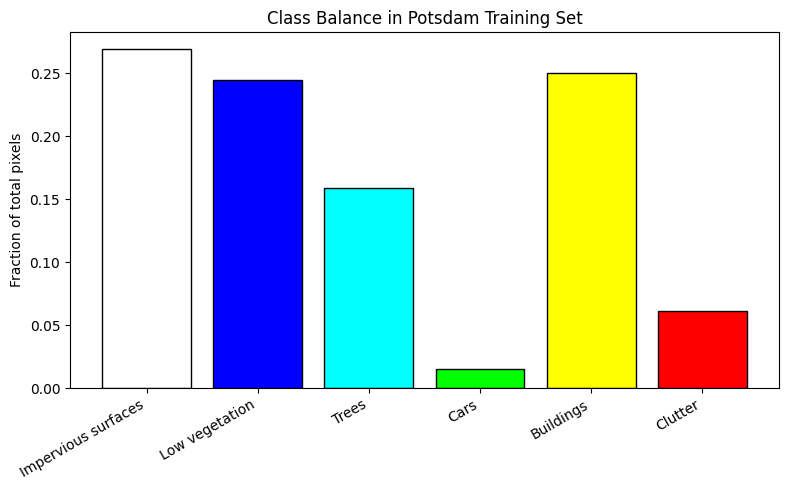

In [19]:
plt.figure(figsize=(8, 5))
class_names = list(class_balance.keys())
fractions = [float(class_balance[name]) for name in class_names]
bars = plt.bar(class_names, fractions, color=[potsdam_plot_kwargs['cmap'](i) for i in range(len(class_names))], edgecolor='black')
plt.ylabel("Fraction of total pixels")
plt.title("Class Balance in Potsdam Training Set")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# sample images per tile

In [ ]:
from collections import defaultdict

# Group image paths by tile (e.g., "top_potsdam_2_11")
tile_to_images = defaultdict(list)
for img_path in train_image_paths:
    tile_id = "_".join(img_path.stem.split("_")[2:4])
    tile_to_images[tile_id].append(img_path)

# Plot 3 random samples per tile
num_samples = 3
tiles = sorted(tile_to_images.keys())
fig, axes = plt.subplots(len(tiles), num_samples, figsize=(num_samples * 5, len(tiles) * 4))

for row_idx, tile_id in enumerate(tiles):
    sample_paths = random.sample(tile_to_images[tile_id], min(num_samples, len(tile_to_images[tile_id])))
    for col_idx, img_path in enumerate(sample_paths):
        label_path = OUT_DIR / "train" / "labels" / img_path.name.replace("_RGB", LABEL_POSTFIX)
        img = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label_img = cv2.imread(str(label_path), cv2.IMREAD_GRAYSCALE)
        
        ax = axes[row_idx, col_idx] if len(tiles) > 1 else axes[col_idx]
        ax.imshow(img)
        ax.set_title(f"{tile_id}\n{img_path.name}", fontsize=10)
        ax.axis('off')
        
        # Overlay label as transparent mask
        ax.imshow(label_img, alpha=0.4, **potsdam_plot_kwargs)

# Add legend to the last subplot
axes[-1, -1].legend(**potsdam_legend_kwargs)
plt.tight_layout()
plt.show()